# Developing of the pipeline

In [33]:
from data_loaders import get_data_module
from utils.visualisation import showInRow

import torch

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import random

from models import get_model, freeze_features, change_output
from models.baseline import BaseLineClassifier, BaseLineClassifierAdam
from models.pretraining.moco import ModifiedMocoV2

from transforms.pretraining import Moco2ChestTransforms
from transforms.finetuning import ChestTransforms
from pl_bolts.models.self_supervised import MocoV2, SimCLR

seed_everything(123456)

123456

# Define datamodule

## Check that data augmentations are good

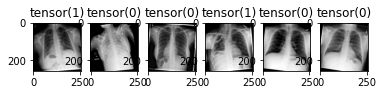

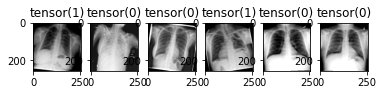

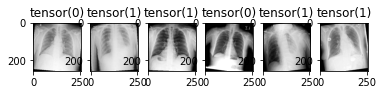

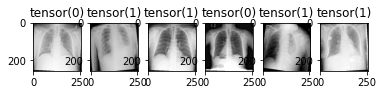

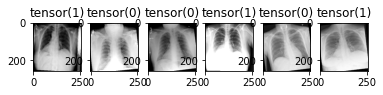

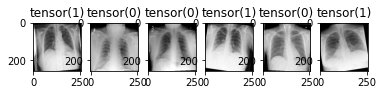

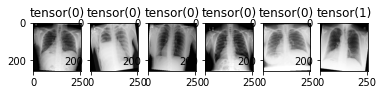

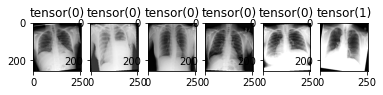

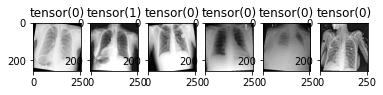

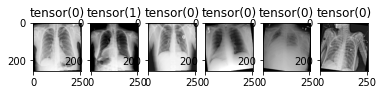

In [2]:
data_module = get_data_module("Chest14", 
                              transform=Moco2ChestTransforms(height=256), 
                              batch_size=6)
batches = 4
for batch in data_module.train_dataloader():
    (img1, img2), labels = batch["image"],batch['label']
    showInRow(img1, labels, tensor=True)
    showInRow(img2, labels, tensor=True)
    batches -=  1
    if batches<0:
        break

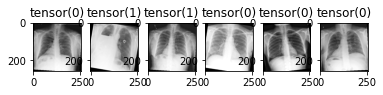

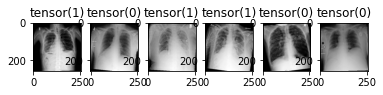

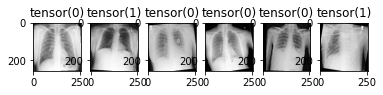

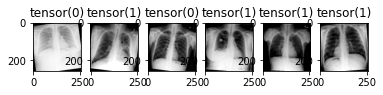

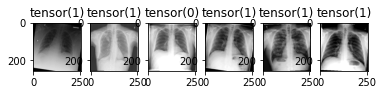

In [3]:
data_module = get_data_module("Chest14", 
                              transform=ChestTransforms(height=256), 
                              batch_size=6)
batches = 4
for batch in data_module.train_dataloader():
    img1, labels = batch["image"],batch['label']
    showInRow(img1, labels, tensor=True)
    batches -=  1
    if batches<0:
        break

In [2]:
data_module = get_data_module("Chest14", 
                              transform=Moco2ChestTransforms(height=256), 
                              batch_size=16, 
                              num_workers=2)

moco_model = ModifiedMocoV2(pretrained = True,
                              base_encoder="resnet18", 
                              num_negatives=65536,
                              batch_size=16,
                              num_workers=2,
                              datamodule=data_module,
                              learning_rate=1e-4)

In [6]:
wandb_logger = WandbLogger(name='moco_pretrain_chest14',project='thesis')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', 
                                      dirpath='logs/pretraining/moco/', 
                                      filename='resnet-Chest14-{epoch:02d}-{val_loss:.4f}')
trainer = pl.Trainer(gpus=1, deterministic=True, logger=wandb_logger, callbacks=[checkpoint_callback])


if torch.cuda.is_available():
    moco_model = moco_model.cuda()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [7]:
trainer.fit(moco_model, data_module)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_step_loss,0.47532
train_step_acc,100.0
train_step_acc5,100.0
epoch,5
_step,22249
_runtime,5663
_timestamp,1606155264
val_loss,0.43572
val_acc,99.98266
val_acc5,100.0
train_epoch_loss,0.42567


train_step_loss,█▇▅▄▃▂▃▂▃▃▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_step_acc,▁▆▇▇████████████████████████████████████
train_step_acc5,▁▆▇█████████████████████████████████████
epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
val_loss,█▄▂▁▁
val_acc,▁▇███
val_acc5,▁▁███
train_epoch_loss,█▃▂▁▁


wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type   | Params
-------------------------------------
0 | encoder_q | ResNet | 11 M  
1 | encoder_k | ResNet | 11 M  


1

# Load model

In [19]:
moco_model = ModifiedMocoV2.load_from_checkpoint("logs/pretraining/moco/resnet-Chest14-epoch=04-val_loss=0.4352.ckpt")

In [24]:
classifier = BaseLineClassifier(get_model("resnet18", pretrained=True), 
#classifier = BaseLineClassifier(moco_model.encoder_q, 
                                num_classes=2, 
                                linear=False,
                                learning_rate=3e-4,
                                momentum=0.9,
                                weight_decay=0.0001)

In [20]:
#classifier = BaseLineClassifierAdam(get_model("resnet18", pretrained=True), 
classifier = BaseLineClassifierAdam(moco_model.encoder_q, 
                                num_classes=2, 
                                linear=False,
                                learning_rate=3e-5,
                                b1=0.9,
                                b2=0.999)

In [31]:
wandb_logger = WandbLogger(name='baseline_resnet_nonlinear_chest_14_full_SGD_3e-4_part2',project='thesis')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', 
                                      dirpath='logs/baseline/chest_14/', 
                                      filename='resnet-full-nonlinear-adam-3e-4_part2-{epoch:02d}-{val_loss:.4f}')

trainer = pl.Trainer(gpus=1, deterministic=True, max_epochs=16,
                     logger=wandb_logger, callbacks=[checkpoint_callback])

if torch.cuda.is_available():
    classifier = classifier.cuda()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [29]:
trainer = pl.Trainer(gpus=1, deterministic=True,
                     logger=wandb_logger, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [26]:
data_module = get_data_module("Chest14", transform=ChestTransforms(height=256), batch_size=16)

In [32]:
trainer.fit(classifier, data_module)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_step_loss,0.63447
train_step_acc,0.5625
epoch,15
_step,142756
_runtime,13422
_timestamp,1606297905
val_loss,0.58202
val_acc,0.7075
train_epoch_loss,0.56386
train_epoch_acc,0.71713
train_lr,0.0003


train_step_loss,▆▄▅█▃▃█▅▁▃▅▄▄▇▃▃▆▁▅▂▂█▅▃▄▅▂▂▅▄▄█▂▂▆▄▃▄▁▄
train_step_acc,▂▅▄▂▅▅▃▃▇▆▄▅▅▁▇▆▁█▃▇▇▂▄▅▆▄▇▆▆▅▅▅▆▇▅▄▅▃▇▅
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
val_loss,▇█▄▅▃▂▄▃▄▃▂▂▁▂▁▁▃
val_acc,▂▁▄▃▅▄▂▆▅▇▆█▇▆▇▇▆
train_epoch_loss,█▇▆▅▅▅▄▄▄▃▂▁▁▁▁▁▃
train_epoch_acc,▁▃▃▄▄▅▅▆▆▆██████▇
train_lr,██████████▁▁▁▁▁▁█


wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name     | Type     | Params
--------------------------------------
0 | model    | ResNet   | 11 M  
1 | accuracy | Accuracy | 0     


1

In [ ]:
simclr_model = SimCLR()